First, lets import the library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from tqdm.auto import tqdm

### Data Cleaning and Preparation

Before displaying the dataset, change the column into lowercase. Then change all of data into lowercase and _ for alternating space

In [2]:
df = pd.read_csv("smart_home_energy_usage.csv")
df.columns = df.columns.str.lower().str.replace(" ", "_")

categorical = ["occupancy_status", "appliance", "day_of_week", "season", "day_of_week"]

for cat in categorical:
    df[cat] = df[cat].str.lower().str.replace(' ', '_')
    
df.head(3)

,timestamp,home_id,energy_consumption_kwh,temperature_setting_c,occupancy_status,appliance,usage_duration_minutes,season,day_of_week,holiday
0,2023-01-01 00:00:00,44,2.87,22.1,occupied,refrigerator,111,spring,sunday,0
1,2023-01-01 01:00:00,81,0.56,15.4,occupied,hvac,103,summer,sunday,0
2,2023-01-01 02:00:00,94,4.49,22.4,occupied,electronics,12,autumn,sunday,0


### Exploratory Data Analysis / Investigation

Before I do train test split, check the datatypes and NaN values before investigating the data

In [3]:
df.dtypes

timestamp                  object
home_id                     int64
energy_consumption_kwh    float64
temperature_setting_c     float64
occupancy_status           object
appliance                  object
usage_duration_minutes      int64
season                     object
day_of_week                object
holiday                     int64
dtype: object

In [4]:
df.isna().sum()

timestamp                 0
home_id                   0
energy_consumption_kwh    0
temperature_setting_c     0
occupancy_status          0
appliance                 0
usage_duration_minutes    0
season                    0
day_of_week               0
holiday                   0
dtype: int64

The data is clean now then I wanna see data from some features, especially from `day_of_week` and `timestamp` columns

In [5]:
df.day_of_week.value_counts()

day_of_week
sunday       142872
monday       142872
tuesday      142864
wednesday    142848
thursday     142848
friday       142848
saturday     142848
Name: count, dtype: int64

In [6]:
df.timestamp

0         2023-01-01 00:00:00
1         2023-01-01 01:00:00
2         2023-01-01 02:00:00
3         2023-01-01 03:00:00
4         2023-01-01 04:00:00
                 ...         
999995    2137-01-29 11:00:00
999996    2137-01-29 12:00:00
999997    2137-01-29 13:00:00
999998    2137-01-29 14:00:00
999999    2137-01-29 15:00:00
Name: timestamp, Length: 1000000, dtype: object

From `timestamp` column, we saw that there are day, month, week, and also time data which had combined into one column. So I want to break this column into year, month, and hour. I also change `day_of_week` column into 0 (Sunday) - 6 (Saturday)

In [7]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["hour"] = df["timestamp"].dt.hour

In [8]:
day_of_week = {
    "sunday": 0,
    "monday": 1,
    "tuesday": 2,
    "wednesday": 3,
    "thursday": 4,
    "friday": 5,
    "saturday": 6
}

df.day_of_week = df.day_of_week.map(day_of_week)

In [9]:
df.head(3)

,timestamp,home_id,energy_consumption_kwh,temperature_setting_c,occupancy_status,appliance,usage_duration_minutes,season,day_of_week,holiday,year,month,hour
0,2023-01-01 00:00:00,44,2.87,22.1,occupied,refrigerator,111,spring,0,0,2023,1,0
1,2023-01-01 01:00:00,81,0.56,15.4,occupied,hvac,103,summer,0,0,2023,1,1
2,2023-01-01 02:00:00,94,4.49,22.4,occupied,electronics,12,autumn,0,0,2023,1,2


After breaking `timestamp` data into several columns and changing `day_of_week` column, I want to plot energy consumption based on the time to get the insight. First analysis is by using year

Text(0, 0.5, 'Energy Consumption (kWh)')

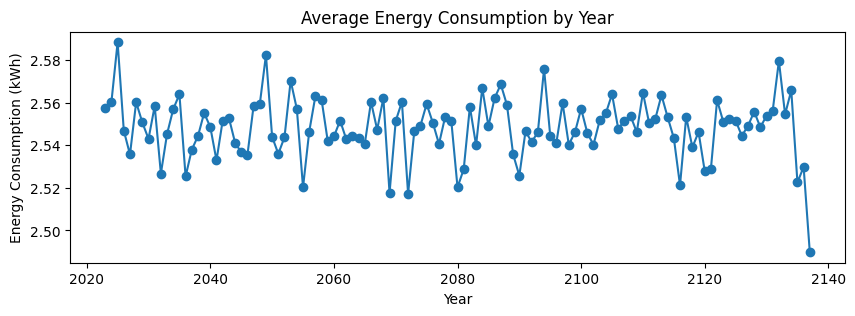

In [10]:
plt.figure(figsize=(10,3)) # for the size of the graph
plt.plot(df.groupby('year')['energy_consumption_kwh'].mean(), marker='o')
plt.title('Average Energy Consumption by Year')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (kWh)')

There's an anomaly from the last point of year and after I checked the dataset, the year data already completed until 2136 so we can delete the last point (2137) because 2137 data is still incomplete, it recorded until january 2137. So I can delete record data in 2137

In [11]:
df =  df[df["year"] != 2137]

From this graph above, it's so hard to know the relationship between energy consumption and year. So in order to know what's the inside of it, I should plot from another features vs energy consumption. But lets see what happens if I plot year vs average energy consumption based on holiday or not....

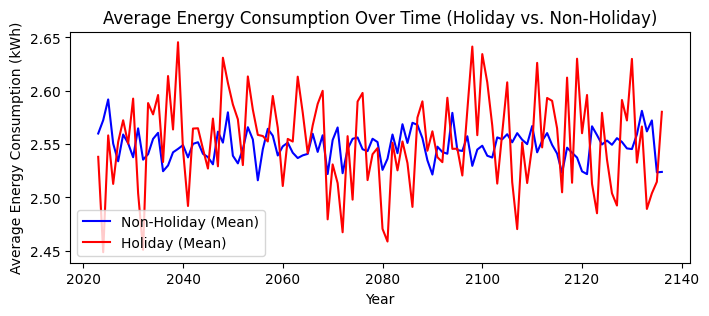

In [12]:
plt.figure(figsize=(8,3))

holiday_mean = df[df["holiday"] == 1].groupby("year")["energy_consumption_kwh"].mean()
non_holiday_mean = df[df["holiday"] == 0].groupby("year")["energy_consumption_kwh"].mean()

plt.plot(non_holiday_mean.index, non_holiday_mean.values, label="Non-Holiday (Mean)", color="blue")
plt.plot(holiday_mean.index, holiday_mean.values, label="Holiday (Mean)", color="red")

plt.title("Average Energy Consumption Over Time (Holiday vs. Non-Holiday)")
plt.xlabel("Year")
plt.ylabel("Average Energy Consumption (kWh)")
plt.legend()

plt.show()

We see that there are fluctuances throughout holiday records than non-holiday records, but we must know what are factors that can affect energy consumption. <br>

I can analyze from months, weeks, or hour. So I plot them based on average entire year from the data which are divided by monthly, weekly, and hourly trends

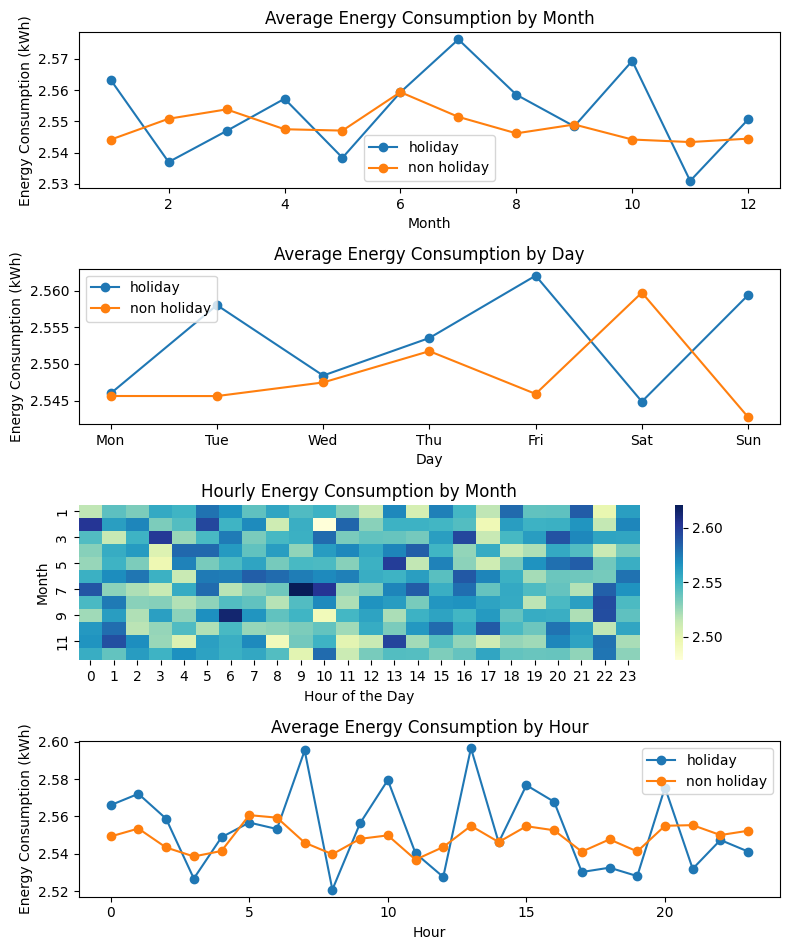

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(8, 10))

# Monthly trends
monthly_avg_holiday = df[df["holiday"] == 1].groupby('month')['energy_consumption_kwh'].mean()
monthly_avg_non_holiday = df[df["holiday"] == 0].groupby('month')['energy_consumption_kwh'].mean()
ax[0].plot(monthly_avg_holiday.index, monthly_avg_holiday.values, marker="o", label="holiday") # for x and y axis
ax[0].plot(monthly_avg_non_holiday.index, monthly_avg_non_holiday.values, marker="o", label="non holiday")
ax[0].set_title('Average Energy Consumption by Month')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Energy Consumption (kWh)')
ax[0].legend()

# Weekly trends
weekly_avg_holiday = df[df["holiday"] == 1].groupby('day_of_week')['energy_consumption_kwh'].mean()
weekly_avg_non_holiday = df[df["holiday"] == 0].groupby('day_of_week')['energy_consumption_kwh'].mean()
ax[1].plot(weekly_avg_holiday.index, weekly_avg_holiday.values, marker="o", label="holiday") # for x and y axis
ax[1].plot(weekly_avg_non_holiday.index, weekly_avg_non_holiday.values, marker="o", label="non holiday")
ax[1].set_title('Average Energy Consumption by Day')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Energy Consumption (kWh)')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax[1].legend()

# Hourly trends
hourly_avg_by_month = df.groupby(['month', 'hour'])['energy_consumption_kwh'].mean().unstack()
sns.heatmap(hourly_avg_by_month, cmap='YlGnBu', ax=ax[2])
ax[2].set_title('Hourly Energy Consumption by Month')
ax[2].set_xlabel('Hour of the Day')
ax[2].set_ylabel('Month')

# Hourly trends
hourly_avg_holiday = df[df["holiday"] == 1].groupby('hour')['energy_consumption_kwh'].mean()
hourly_avg_non_holiday = df[df["holiday"] == 0].groupby('hour')['energy_consumption_kwh'].mean()
ax[3].plot(hourly_avg_holiday.index, hourly_avg_holiday.values, marker="o", label="holiday") # for x and y axis
ax[3].plot(hourly_avg_non_holiday.index, hourly_avg_non_holiday.values, marker="o", label="non holiday")
ax[3].set_title('Average Energy Consumption by Hour')
ax[3].set_xlabel('Hour')
ax[3].set_ylabel('Energy Consumption (kWh)')
ax[3].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit main title
plt.show()

From this graph, some possible analysis which I can make from that plot are....
- Plot 1: Peak consumption during holiday is from July and October
- Plot 2: The most frequent of consumption in holiday is in Tuesday, Friday, and Sunday whereas in non-holiday is in Saturday
- Plot 3: You can see during in June, a lot of energies consumed in the Morning (from 5 AM - 11 AM)

<Axes: xlabel='energy_consumption_kwh', ylabel='Count'>

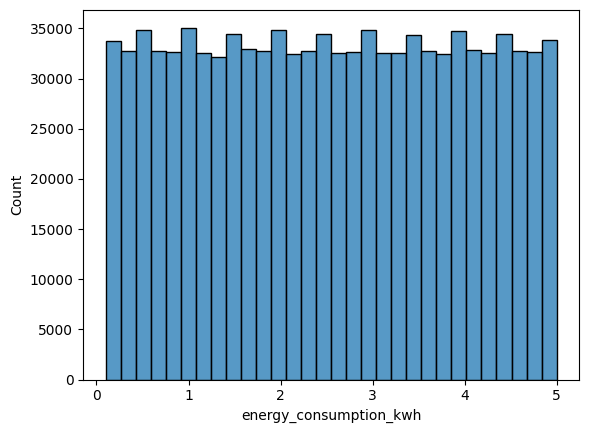

In [14]:
sns.histplot(df.energy_consumption_kwh, bins=30)

From this plot above we can see that those data are uniformly distributed so the possible model which I can use are decision tree, random forest, and XGBoost because it works well with uniform distributions <br>

To check how many values from some parameters, I can use describe from some numerical data except `home_id`, `day_of_week`, `holiday`, `year`, `month`, and `hour`

In [15]:
df.dtypes

timestamp                 datetime64[ns]
home_id                            int64
energy_consumption_kwh           float64
temperature_setting_c            float64
occupancy_status                  object
appliance                         object
usage_duration_minutes             int64
season                            object
day_of_week                        int64
holiday                            int64
year                               int32
month                              int32
hour                               int32
dtype: object

In [16]:
df[["energy_consumption_kwh", "temperature_setting_c", "usage_duration_minutes"]].describe()

,energy_consumption_kwh,temperature_setting_c,usage_duration_minutes
count,999312.000000,999312.000000,999312.000000
mean,2.548879,19.999201,59.505204
std,1.415538,2.887718,34.651012
min,0.100000,15.000000,0.000000
25%,1.320000,17.500000,30.000000
50%,2.550000,20.000000,59.000000
75%,3.780000,22.500000,90.000000
max,5.000000,25.000000,119.000000


### Train Test Split

In this step, I don't need `home_id` column so I can delete it...

In [17]:
del df["home_id"]

then splitting the data into `df_train`, `df_valid`, and `df_test`. But we will also make `df_full_train` to check correlation

In [18]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.energy_consumption_kwh.values
y_valid = df_valid.energy_consumption_kwh.values
y_test = df_test.energy_consumption_kwh.values

df_train = df_train.drop(["energy_consumption_kwh", "timestamp"], axis=1)
df_valid = df_valid.drop(["energy_consumption_kwh", "timestamp"], axis=1)
df_test = df_test.drop(["energy_consumption_kwh", "timestamp"], axis=1)

In [19]:
df_train

,temperature_setting_c,occupancy_status,appliance,usage_duration_minutes,season,day_of_week,holiday,year,month,hour
0,17.6,occupied,dishwasher,29,winter,2,0,2044,4,2
1,21.8,unoccupied,refrigerator,38,spring,2,0,2100,6,5
2,22.2,unoccupied,electronics,107,spring,6,0,2109,7,19
3,20.3,unoccupied,lighting,45,winter,5,0,2102,7,10
4,18.5,occupied,washing_machine,119,autumn,1,0,2123,7,0
...,...,...,...,...,...,...,...,...,...,...
599581,20.1,unoccupied,washing_machine,116,autumn,5,0,2110,2,23
599582,24.2,unoccupied,electronics,68,autumn,2,0,2031,9,7
599583,17.3,occupied,dishwasher,49,spring,0,1,2090,3,8
599584,17.5,unoccupied,electronics,15,spring,1,0,2051,7,23


Check the length of the data...

In [20]:
len(df_train), len(df_valid), len(df_test)

(599586, 199863, 199863)

### Feature Importance: Correlation

Check the correlation between numerical features vs energy consumption by using `df_full_train`

In [21]:
numerical = ["temperature_setting_c", "usage_duration_minutes", "day_of_week", "holiday", "year", "month", "hour"]

In [22]:
df_full_train[numerical].corrwith(df_full_train.energy_consumption_kwh).abs().sort_values(ascending=False)

month                     0.001097
hour                      0.000933
temperature_setting_c     0.000879
day_of_week               0.000621
usage_duration_minutes    0.000493
holiday                   0.000194
year                      0.000156
dtype: float64

Turns out there are weak relationships between numerical features vs energy consumption. <br><br>
So I want to know the relationship between every numerical features except y = energy consumption

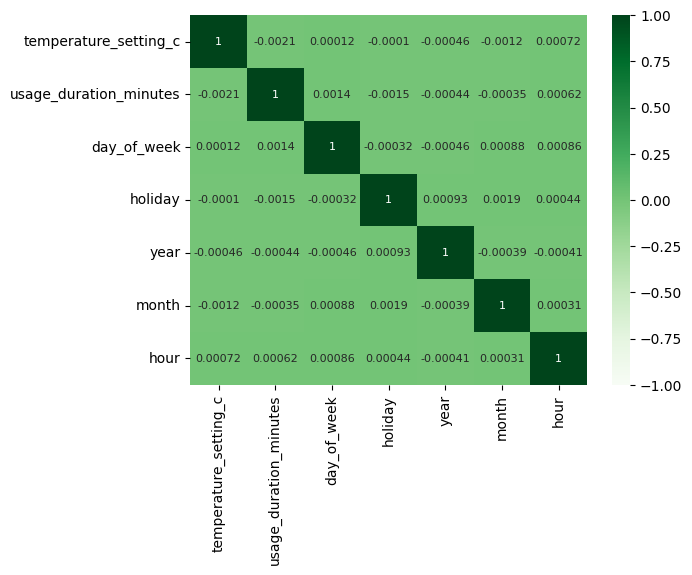

In [23]:
corr = df_full_train[numerical].corr()

axis_corr = sns.heatmap(corr, annot=True, annot_kws={"size":8}, vmin=-1, vmax=1, cmap="Greens")
plt.show()

The relationship between those features are so small, so we can move into the model

### Decision Tree

Before using decision tree, I want to encode all categorical data from train and validation data...

In [24]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

valid_dicts = df_valid.to_dict(orient='records')
X_valid = dv.transform(valid_dicts)

then, I can state the decision tree model. Since the goal from this dataset is I want to predict energy consumption so I can use decision tree regressor

In [25]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

Because this is a regression concept, the evaluation metrics that are gonna be used are RMSE and r2
- RMSE: Measuring the accuracy or goodness of fit of a predictive model
- R2: Evaluating the overall performance effectiveness of a model.

In [26]:
y_pred = dt.predict(X_valid)
rmse = root_mean_squared_error(y_valid,y_pred)
r2 = r2_score(y_valid, y_pred)

print(F"RMSE: {rmse} and R2 scores: {r2}")

RMSE: 2.0275159508528433 and R2 scores: -1.0515211277566259


if I compare to train data...

In [27]:
y_pred = dt.predict(X_train)
rmse = root_mean_squared_error(y_train,y_pred)
r2 = r2_score(y_train, y_pred)

print(F"RMSE: {rmse} and R2 scores: {r2}")

RMSE: 0.003672472745805937 and R2 scores: 0.9999932691081898


From those results, this indicates that my model is overfit because:
- RMSE in validation is too high than RMSE in training. Basically, **low RMSE in validation shows that the model makes more accurate predictions and fits the data well. Higher levels, on the other hand, imply more significant mistakes and fewer accurate forecasts.**
- R2 from validation is smaller than r2 from train. Basically, **r2 generate values between 0 to 1**

Those trees from result above are too deep, so I can check how many depths of the trees by this...

In [28]:
tree_depth = dt.get_depth()
print(tree_depth)

58


We can do hyperparameter tuning from now...

In [29]:
results = []

for d in tqdm([6,7,8,9,10]):
    for s in [2,4,6,8,10,15,20]:
        dt = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_valid)
        rmse = root_mean_squared_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)

        results.append([d, s, rmse, r2])

df_results = pd.DataFrame(results, columns=["max_depth", "min_samples_leaf", "rmse", "r2"])
df_results.sort_values(by="rmse", ascending=True).head()

  0%|          | 0/5 [00:00<?, ?it/s]

,max_depth,min_samples_leaf,rmse,r2
5,6,15,1.416046,-0.000695
4,6,10,1.416061,-0.000717
3,6,8,1.416069,-0.000728
6,6,20,1.416078,-0.000742
0,6,2,1.416081,-0.000746


We can see that rmse values after I tuned in is slightly better than before tuned in. The lowest rmse which I could get is when the `max_depth=6` and `min_samples_leaf=15`. So we choose these values to compare results from different models

In [30]:
dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=15)

### Random Forest

We can directly do hyperparameter tuning now. The first parameter is from depth...

In [31]:
results = []

for d in tqdm([6,7,8,9,10]):
    rf = RandomForestRegressor(n_estimators=0, max_depth=d, random_state=1, n_jobs=-1, warm_start=True)

    for n in tqdm(range(20, 201, 20)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_valid)
        rmse = root_mean_squared_error(y_valid,y_pred)
        r2 = r2_score(y_valid, y_pred)
        
        results.append((d, n, rmse, r2))

df_results = pd.DataFrame(results, columns=["max_depth", "n_estimators", "rmse", "r2"])
df_results.head()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,max_depth,n_estimators,rmse,r2
0,6,20,1.415677,-0.000175
1,6,40,1.415644,-0.000128
2,6,60,1.415639,-0.000121
3,6,80,1.415644,-0.000128
4,6,100,1.415638,-0.000119


plot the results...

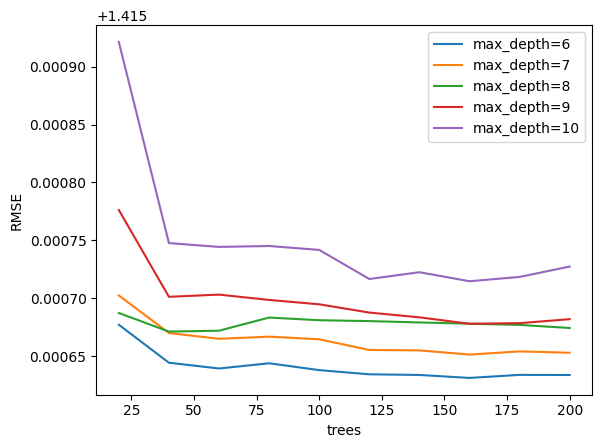

In [32]:
for d in [6,7,8,9,10]:
    df_subset = df_results[df_results.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label="max_depth=%d" % d)

plt.legend()

plt.xlabel("trees")
plt.ylabel("RMSE")

plt.show()

We see that the good performance here which generated the lowest rmse is from `max_depth=6`. So I can choose that for tuning other parameters.

In [33]:
max_depth = 6

Do hyperparameter tuning to find leaves...

In [34]:
results = []

for s in [2,4,6,8,10,15,20]:
    for n in tqdm(range(20, 201, 20)):
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1, n_jobs=-1, warm_start=True)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_valid)
        rmse = root_mean_squared_error(y_valid,y_pred)
        r2 = r2_score(y_valid, y_pred)
        
        results.append((s, n, rmse, r2))

df_results = pd.DataFrame(results, columns=["min_samples_leaf", "n_estimators", "rmse", "r2"])
df_results.head()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,min_samples_leaf,n_estimators,rmse,r2
0,2,20,1.415683,-0.000182
1,2,40,1.415647,-0.000132
2,2,60,1.415641,-0.000123
3,2,80,1.415646,-0.000131
4,2,100,1.415639,-0.000120


Plot the results...

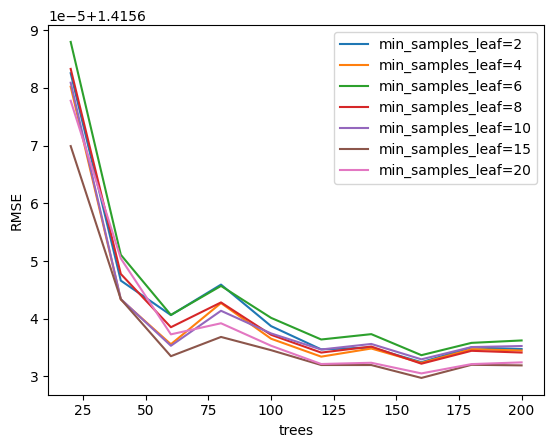

In [35]:
for s in [2,4,6,8,10,15,20]:
    df_subset = df_results[df_results.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label="min_samples_leaf=%s" % s)

plt.legend()

plt.xlabel("trees")
plt.ylabel("RMSE")

plt.show()

And we see that the lowest rmse is from `min_samples_leaf=15`. After that, I set this leaf to compare other models. For the `n_estimators` that I am going to use, I assume that my `n_estimators=200`

In [36]:
min_samples_leaf = 15

In [37]:
rf = RandomForestRegressor(n_estimators=200, max_depth=6, min_samples_leaf=15, random_state=1, n_jobs=-1, warm_start=True)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=15, n_estimators=200,
                      n_jobs=-1, random_state=1, warm_start=True)

### LightGBM

Do hyperparameter tuning for another model. First is from `max_depth`

In [38]:
results = []

for d in tqdm([6,7,8,9,10]):
    for n in tqdm(range(20, 201, 20)):
        lgbr = lgb.LGBMRegressor(n_estimators=n, max_depth=d, learning_rate=0.1, random_state=1, verbose=-1, n_jobs=-1)
        lgbr.fit(X_train, y_train)

        y_pred = lgbr.predict(X_valid)
        rmse = root_mean_squared_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)

        results.append((d, n, rmse, r2))

# Save results in a DataFrame
df_results = pd.DataFrame(results, columns=["max_depth", "n_estimators", "rmse", "r2"])
df_results.head()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,max_depth,n_estimators,rmse,r2
0,6,20,1.415650,-0.000137
1,6,40,1.415710,-0.000222
2,6,60,1.415805,-0.000355
3,6,80,1.415916,-0.000512
4,6,100,1.416020,-0.000659


Plot the results...

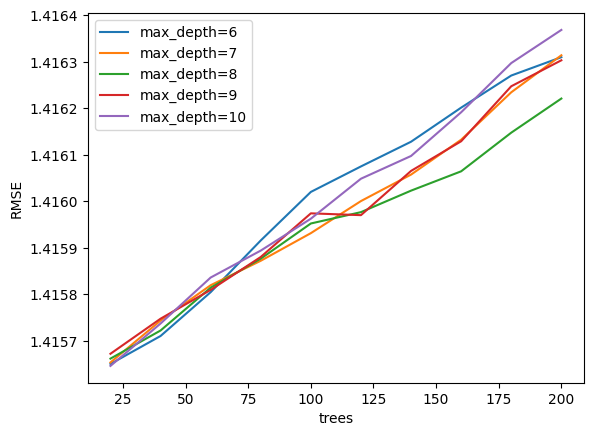

In [39]:
for d in [6,7,8,9,10]:
    df_subset = df_results[df_results.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label="max_depth=%d" % d)

plt.legend()

plt.xlabel("trees")
plt.ylabel("RMSE")

plt.show()

We saw that `max_depth=8` is the lowest result for rmse, so we can use it for tuning other parameters...

In [40]:
max_depth = 8

Tune `learning_rate` and plot the results

In [41]:
results = []

for lr in tqdm([0.1, 0.3, 0.5, 1]):
    for n in tqdm(range(20, 201, 20)):
        lgbr = lgb.LGBMRegressor(n_estimators=n, max_depth=max_depth, learning_rate=lr, random_state=1, verbose=-1, n_jobs=-1)
        lgbr.fit(X_train, y_train)

        y_pred = lgbr.predict(X_valid)
        rmse = root_mean_squared_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)

        results.append((lr, n, rmse, r2))

# Save results in a DataFrame
df_results = pd.DataFrame(results, columns=["learning_rate", "n_estimators", "rmse", "r2"])
df_results.head()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,learning_rate,n_estimators,rmse,r2
0,0.1,20,1.415662,-0.000153
1,0.1,40,1.415722,-0.000238
2,0.1,60,1.415814,-0.000368
3,0.1,80,1.415877,-0.000456
4,0.1,100,1.415952,-0.000563


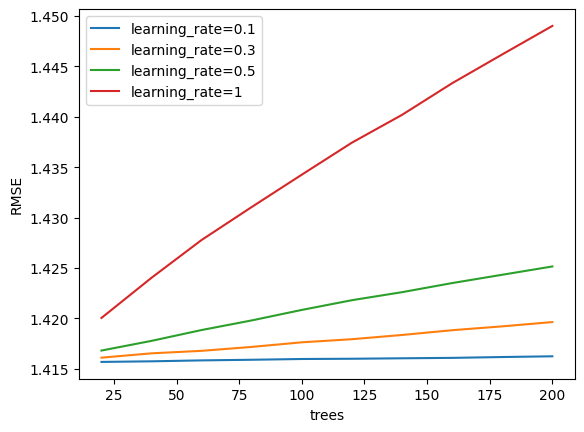

In [42]:
for lr in [0.1, 0.3, 0.5, 1]:
    df_subset = df_results[df_results.learning_rate == lr]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label="learning_rate=%lr" % lr)

plt.legend()

plt.xlabel("trees")
plt.ylabel("RMSE")

plt.show()

And we can see that `learning_rate=0.1` is the best value for set this model

In [43]:
learning_rate = 0.1

Tuning leaves now and plot it

In [44]:
results = []

for s in tqdm([2,4,6,8,10,15,20]):
    for n in tqdm(range(20, 201, 20)):
        lgbr = lgb.LGBMRegressor(n_estimators=n, max_depth=max_depth, learning_rate=learning_rate, random_state=1, verbose=-1, n_jobs=-1, min_data_in_leaf=s)
        lgbr.fit(X_train, y_train)

        y_pred = lgbr.predict(X_valid)
        rmse = root_mean_squared_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)

        results.append((s, n, rmse, r2))

# Save results in a DataFrame
df_results = pd.DataFrame(results, columns=["min_data_in_leaf", "n_estimators", "rmse", "r2"])
df_results.head()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,min_data_in_leaf,n_estimators,rmse,r2
0,2,20,1.415652,-0.000140
1,2,40,1.415736,-0.000258
2,2,60,1.415810,-0.000363
3,2,80,1.415881,-0.000463
4,2,100,1.415955,-0.000567


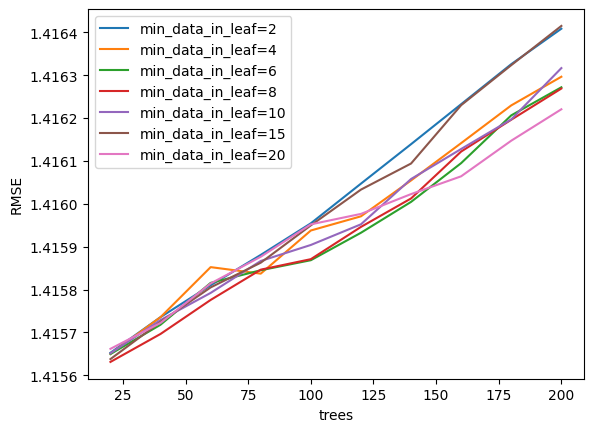

In [45]:
for s in [2,4,6,8,10,15,20]:
    df_subset = df_results[df_results.min_data_in_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label="min_data_in_leaf=%s" % s)

plt.legend()

plt.xlabel("trees")
plt.ylabel("RMSE")

plt.show()

and I get the result that `min_data_in_leaf = 20` is the best value

In [46]:
min_data_in_leaf = 20

Now, we define LightGBM model based on chosen values from tuning parameters

In [47]:
lgbr = lgb.LGBMRegressor(n_estimators=200, max_depth=max_depth, learning_rate=learning_rate, random_state=1, verbose=-1, n_jobs=-1, min_data_in_leaf=min_data_in_leaf)
lgbr.fit(X_train, y_train)

LGBMRegressor(max_depth=8, min_data_in_leaf=20, n_estimators=200, n_jobs=-1,
              random_state=1, verbose=-1)

### Summary

This contains a comparison between all of models which I used for this notebook

In [48]:
dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_valid)
rmse = root_mean_squared_error(y_valid,y_pred)
r2 = r2_score(y_valid, y_pred)

print(F"RMSE: {rmse} and R2 scores: {r2}")

RMSE: 1.4160455020922589 and R2 scores: -0.0006952826771835507


In [49]:
rf = RandomForestRegressor(n_estimators=200, max_depth=6, min_samples_leaf=15, random_state=1, n_jobs=-1, warm_start=True)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)
rmse = root_mean_squared_error(y_valid,y_pred)
r2 = r2_score(y_valid, y_pred)

print(F"RMSE: {rmse} and R2 scores: {r2}")

RMSE: 1.4156319056141056 and R2 scores: -0.00011080484693248849


In [50]:
lgbr = lgb.LGBMRegressor(n_estimators=200, max_depth=8, learning_rate=0.1, random_state=1, verbose=-1, n_jobs=-1, min_data_in_leaf=20)
lgbr.fit(X_train, y_train)

y_pred = lgbr.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(F"RMSE: {rmse} and R2 scores: {r2}")

RMSE: 1.4162205739735156 and R2 scores: -0.0009427386175737684


We see that the best model is from Random Forest Regression which generates the lowest rmse. <br><br>
Now we can try this model for predicting in test dataframe

In [51]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.energy_consumption_kwh.values

df_full_train = df_full_train.drop(["energy_consumption_kwh", "timestamp"], axis=1)

In [52]:
dv = DictVectorizer(sparse=False)

full_train_dicts = df_full_train.to_dict(orient="records")
X_full_train = dv.fit_transform(full_train_dicts)

test_dicts = df_test.to_dict(orient="records")
X_test = dv.transform(test_dicts)

In [53]:
rf = RandomForestRegressor(n_estimators=200, max_depth=6, min_samples_leaf=15, random_state=1, n_jobs=-1, warm_start=True)
rf.fit(X_full_train, y_full_train)
y_pred = rf.predict(X_test)

rmse = root_mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

print(F"RMSE: {rmse} and R2 scores: {r2}")

RMSE: 1.415530882102951 and R2 scores: -4.130857000905763e-05


This is the final result from predict test dataframe by using Random Forest Regression